In [249]:
import warnings
warnings.filterwarnings("ignore")

In [250]:
import numpy as np
import pandas as pd
import unicodedata
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import yfinance as yf
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import empyrical as emp
import seaborn as sns

<h3> Sentiment Analysis </h3>

In [251]:
all_tweets = pd.read_csv('data/stock_tweets.csv')

# Get the number of tweets for each stock
tweet_counts = all_tweets.groupby(['Stock Name']).count()

min_tweets = 500

# Get the stock names with more than 500 tweets
stocks_name = tweet_counts[tweet_counts['Company Name'] >= min_tweets]

# Get the tweets for the stocks with more than 500 tweets
stocks_tweets = all_tweets[all_tweets['Stock Name'].isin(stocks_name.index)]

# Display the number of tweets for each stock
# print(stocks_tweets.groupby(['Stock Name']).count())

# Get the sentiment for each tweet
sentiment_stocks = stocks_tweets.copy()

sentiment_stocks["sentiment_score"] = ''
sentiment_stocks["Negative"] = ''
sentiment_stocks["Neutral"] = ''
sentiment_stocks["Positive"] = ''

sentiment_analyzer = SentimentIntensityAnalyzer()

for index, row in sentiment_stocks.iterrows():
    try:
        # Normalize the text
        sentence_i = unicodedata.normalize('NFKD', row['Tweet'])
        
        # Calculate sentiment scores
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        
        # Update the DataFrame with sentiment scores
        sentiment_stocks.at[index, 'sentiment_score'] = sentence_sentiment['compound']
        sentiment_stocks.at[index, 'Negative'] = sentence_sentiment['neg']
        sentiment_stocks.at[index, 'Neutral'] = sentence_sentiment['neu']
        sentiment_stocks.at[index, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print(row['Tweet'])
        print(index)
        break

sentiment_stocks["Date"] = pd.to_datetime(sentiment_stocks["Date"])
sentiment_stocks['Date'] = sentiment_stocks['Date'].dt.date
sentiment_stocks = sentiment_stocks.sort_values(by='Date')
sentiment_stocks = sentiment_stocks.drop(columns=['Negative', 'Positive', 'Neutral', 'Company Name', 'Tweet'])
sentiment_stocks["count"] = 1

In [252]:
# count for the number of tweet each day for each stock and calculate the average sentiment score
sentiment_stocks = sentiment_stocks.groupby(['Stock Name', 'Date']).agg({'sentiment_score': 'mean', 'count': 'sum'})

date_range = sentiment_stocks.loc["AAPL"].index
# filter the sentiment_stocks to only include the date range of the stock data
sentiment_stocks = sentiment_stocks[sentiment_stocks.index.get_level_values('Date').isin(date_range)]

<h3> Stock </h3>

In [253]:
sentiment_start ="2021-09-30"
sentiment_end = "2022-09-29"

stock_start = "2021-08-07"
stock_end = sentiment_end

# stock_list = ['AAPL', 'AMD', 'AMZN', 'DIS', 'GOOG', 'META', 'MSFT', 'NFLX', 'NIO', 'PG', 'PYPL', 'TSLA', 'TSM']
stock_list = ['AAPL', 'AMD', 'AMZN', 'GOOG', 'META', 'MSFT', 'NIO', 'PG', 'TSLA', 'TSM']

stock_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'sentiment_score']
# stock_features = ['Volume', 'Adj Close', 'sentiment_score']


In [254]:
stock_data = yf.download(stock_list, start= stock_start, end= stock_end)
stock_price = stock_data[['Adj Close']]

stock_logreturn = stock_price.apply(np.log).diff().dropna()
stock_absreturn = stock_logreturn.abs()

stock_data = stock_data.swaplevel(axis=1)

[*********************100%%**********************]  10 of 10 completed


In [255]:
target_stock = stock_list[9]

In [256]:
df = stock_data[target_stock].join(sentiment_stocks.loc[target_stock], how='left')

In [257]:
def add_features(df):
    df["log_return"] = df.agg({'Adj Close': np.log}).diff()
    # the label is 1 if the log return of the next day is positive and -1 if it is negative
    df["label"] = np.where(df["log_return"] > 0, 1, -1)
    # get the next day label for the stock (our target)
    df["label"] = df["label"].shift(-1)

    df = df[df.index.get_level_values('Date').isin(date_range)]

    df["sentiment_score"] = df["sentiment_score"].fillna(method='ffill')
    df["sentiment_score"] = df["sentiment_score"].fillna(0)

    # get the next day sentiment score for the stock
    df["next_sentiment"] = df["sentiment_score"].shift(-1)
    # moving average of stock price for 7 and 14 days
    df["price_MA_7"] = df["Adj Close"].rolling(window=7).mean()
    df["price_MA_14"] = df["Adj Close"].rolling(window=14).mean()
    
    # df["MACD"] = df["Adj Close"].ewm(span=26).mean() - df["Open"].ewm(span=12, adjust=False).mean()

    # df["14SD"] = df["Adj Close"].rolling(14).std()
    # df["upper_band"] = df["price_MA_14"] + 2 * df["14SD"]
    # df["lower_band"] = df["price_MA_14"] - 2 * df["14SD"]

    # df["EMA"] = df["Adj Close"].ewm(com=0.5).mean()

    # df['log_momentum'] = np.log(df['Adj Close'] - 1)

    # moving average of sentiment score for 7 and 14 days
    df["sentiment_MA_7"] = df["sentiment_score"].rolling(window=7).mean()
    df["sentiment_MA_14"] = df["sentiment_score"].rolling(window=14).mean()
    # moving average of volume for 7 and 14 days
    df["volume_MA_7"] = df["Volume"].rolling(window=7).mean()
    df["volume_MA_14"] = df["Volume"].rolling(window=14).mean()
    # moving average of log return for 7 and 14 days
    df["log_return_MA_7"] = df["log_return"].rolling(window=7).mean()
    df["log_return_MA_14"] = df["log_return"].rolling(window=14).mean()
    return df

In [260]:
def get_predictions_result(y_test, y_pred, rebalance_period, total_windows):
    pred_labels = np.zeros(total_windows)
    real_labels = np.zeros(total_windows)
    for i in range(total_windows):
        tst_start = i * rebalance_period
        tst_end = tst_start + rebalance_period
        pred_mean = np.mean(y_pred[tst_start:tst_end])
        pred_labels[i] = np.sign(pred_mean)
        read_mean = np.mean(y_test[tst_start:tst_end])
        real_labels[i] = np.sign(read_mean)
    return pred_labels, real_labels

In [261]:
rebalance_period = 5
accruacy_df = pd.DataFrame(columns=['LR', 'RF', 'AB', 'LR_PCA', 'RF_PCA', 'AB_PCA'])
label_df = pd.DataFrame(columns=['Real', 'LR', 'RF', 'AB', 'LR_PCA', 'RF_PCA', 'AB_PCA'])
date_range = sentiment_stocks.loc["AAPL"].index
N = len(stock_list)

for i in range(len(stock_list)):
    target_stock = stock_list[i]
    df = stock_data[target_stock].join(sentiment_stocks.loc[target_stock], how='left')
    data = add_features(df[stock_features])
    data_label = data.loc[sentiment_start:] 

    # empty_df = data_label[data_label["sentiment_score"].isnull()]
    # print(empty_df.index)
    
    data_label = data_label.dropna()

    T = len(data_label)
    train_size = int(T * 0.5)
    total_windows = int((T - train_size) / rebalance_period)

    X = data_label.drop(columns=['label'])
    y = data_label['label']

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]

    # Logistic Regression
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train, y_train)
    logistic_y_pred = logistic_regression.predict(X_test)
    logistic_regression_pred_labels, logistic_regression_real_labels = get_predictions_result(y_test, logistic_y_pred, rebalance_period, total_windows)
    logistic_regression_accuracy = accuracy_score(logistic_regression_real_labels, logistic_regression_pred_labels)

    # Random Forest
    random_forest = RandomForestClassifier(max_depth=5, n_estimators=100, min_samples_split=5, random_state=0)
    random_forest.fit(X_train, y_train)
    rf_y_pred = random_forest.predict(X_test)
    rf_pred_labels, rf_real_labels = get_predictions_result(y_test, rf_y_pred, rebalance_period, total_windows)
    rf_accuracy = accuracy_score(rf_real_labels, rf_pred_labels)

    # AdaBoost
    ada_boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=50, random_state=0)
    ada_boost.fit(X_train, y_train)
    ada_y_pred = ada_boost.predict(X_test)
    ada_pred_labels, ada_real_labels = get_predictions_result(y_test, ada_y_pred, rebalance_period, total_windows)
    ada_accuracy = accuracy_score(ada_real_labels, ada_pred_labels)

    # PCA
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Logistic Regression with PCA
    logistic_regression_pca = LogisticRegression()
    logistic_regression_pca.fit(X_train_pca, y_train)
    logistic_y_pred_pca = logistic_regression_pca.predict(X_test_pca)
    logistic_regression_pred_labels_pca, logistic_regression_real_labels_pca = get_predictions_result(y_test, logistic_y_pred_pca, rebalance_period, total_windows)
    logistic_regression_accuracy_pca = accuracy_score(logistic_regression_real_labels_pca, logistic_regression_pred_labels_pca)

    # Random Forest with PCA
    random_forest_pca = RandomForestClassifier(max_depth=5, n_estimators=50, min_samples_split=5, random_state=0)
    random_forest_pca.fit(X_train_pca, y_train)
    rf_y_pred_pca = random_forest_pca.predict(X_test_pca)
    rf_pred_labels_pca, rf_real_labels_pca = get_predictions_result(y_test, rf_y_pred_pca, rebalance_period, total_windows)
    rf_accuracy_pca = accuracy_score(rf_real_labels_pca, rf_pred_labels_pca)

    # AdaBoost with PCA
    ada_boost_pca = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=50, random_state=0)
    ada_boost_pca.fit(X_train_pca, y_train)
    ada_y_pred_pca = ada_boost_pca.predict(X_test_pca)
    ada_pred_labels_pca, ada_real_labels_pca = get_predictions_result(y_test, ada_y_pred_pca, rebalance_period, total_windows)
    ada_accuracy_pca = accuracy_score(ada_real_labels_pca, ada_pred_labels_pca)


    accruacy_df.loc[stock_list[i]] = [logistic_regression_accuracy, rf_accuracy, ada_accuracy, logistic_regression_accuracy_pca, rf_accuracy_pca, ada_accuracy_pca]
    label_df.loc[stock_list[i]] = [logistic_regression_real_labels, logistic_regression_pred_labels, rf_pred_labels, ada_pred_labels, logistic_regression_pred_labels_pca, rf_pred_labels_pca, ada_pred_labels_pca]

accruacy_df.loc["Model Mean"] = accruacy_df.mean()  

In [262]:
data_label.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
       'sentiment_score', 'log_return', 'label', 'next_sentiment',
       'price_MA_7', 'price_MA_14', 'sentiment_MA_7', 'sentiment_MA_14',
       'volume_MA_7', 'volume_MA_14', 'log_return_MA_7', 'log_return_MA_14'],
      dtype='object')

In [263]:
display(accruacy_df)
# display(label_df)
# display(accruacy_df.mean(axis=0))

,LR,RF,AB,LR_PCA,RF_PCA,AB_PCA
AAPL,0.391304,0.565217,0.521739,0.391304,0.608696,0.608696
AMD,0.565217,0.217391,0.217391,0.782609,0.217391,0.782609
AMZN,0.391304,0.565217,0.608696,0.521739,0.521739,0.521739
GOOG,0.608696,0.347826,0.304348,0.652174,0.652174,0.347826
META,0.565217,0.434783,0.347826,0.565217,0.565217,0.565217
MSFT,0.478261,0.391304,0.347826,0.391304,0.391304,0.391304
NIO,0.434783,0.521739,0.739130,0.521739,0.521739,0.521739
PG,0.391304,0.478261,0.434783,0.391304,0.608696,0.608696
TSLA,0.608696,0.478261,0.521739,0.478261,0.478261,0.478261
TSM,0.565217,0.608696,0.434783,0.304348,0.304348,0.695652


In [264]:
def MVP(mu, Sigma, w_old, Lambda=0.1):
    w = cp.Variable(N)
    variance = cp.quad_form(w, Sigma)
    expected_return = w @ mu
    turnover = cp.norm(w - w_old, 1) / 2

    objective = cp.Maximize(expected_return - Lambda * variance)

    constraints = [
        w >= -0.2,     
        w <= 0.2,   
        # w >= 0,
        # w <= 0.3,
        cp.sum(w) == 1,     # fully invested
        variance <= 0.1**2,     # max 10% variance
        turnover <= 0.15,
        # turnover <= 0.15,    # max 15% turnover
        ]

    problem = cp.Problem(objective=objective, constraints = constraints)

    problem.solve()
    return w.value

In [265]:
stock_back_period = 100
w_old = np.ones(N)/N
weights = np.zeros((total_windows, N))
for i in range(total_windows):
    trt_start = i * rebalance_period
    trt_end = trt_start + stock_back_period
    train_data = stock_logreturn["Adj Close"].iloc[trt_start:trt_end]
    mu = train_data.mean().values
    Sigma = train_data.cov().values
    w_old = MVP(mu, Sigma, w_old)
    weights[i] = w_old

In [266]:
test_return = stock_logreturn["Adj Close"].iloc[stock_back_period:]
def get_returns(df, T_roll, num_windows, train_cycle=0):
    w_init = np.array(df[1]) 
    w_dynamic = np.array(df)
    static_return = test_return[train_cycle*T_roll:115] @ w_init
    dynamic_return = np.array([])
    w_EWP = np.zeros(N) + 1/N
    EWP_return = test_return[train_cycle*T_roll:115]  @ w_EWP
    for i in range(num_windows):
        test_start = i*T_roll + train_cycle*T_roll
        test_end = test_start + T_roll
        rtr = test_return[test_start:test_end] @ w_dynamic[:,i]
        dynamic_return = np.append(dynamic_return, rtr)

    return static_return, dynamic_return, EWP_return

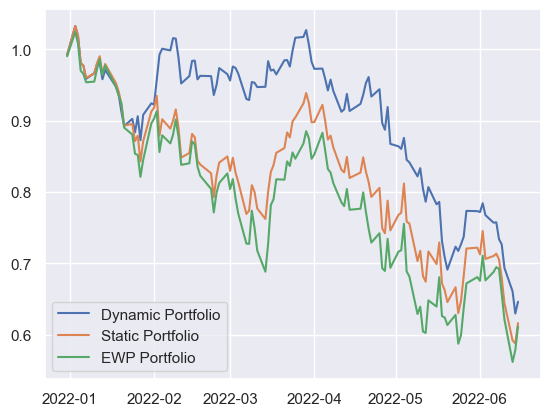

In [267]:
weights_df = pd.DataFrame(weights, columns=stock_list).T
weights_df.columns = range(1, total_windows+1)

static_return, dynamic_return, EWP_return = get_returns(weights_df, rebalance_period, total_windows)
dynamic_plot = 1 + np.cumsum(dynamic_return)
static_plot = 1 + np.cumsum(static_return)
EWP_plot = 1 + np.cumsum(EWP_return)


plt.plot(test_return.index[:len(dynamic_plot)],dynamic_plot, label='Dynamic Portfolio')
plt.plot(static_plot, label='Static Portfolio')
plt.plot(EWP_plot, label='EWP Portfolio')
plt.legend()
plt.show()

In [268]:
evaluation = pd.DataFrame(columns=['Dynamic Portfolio', 'Static Portfolio', 'EWP Portfolio'])
# round the result to 4 decimal places
evaluation.loc['Annual Return'] = [round(emp.annual_return(dynamic_return), 4), round(emp.annual_return(static_return), 4), round(emp.annual_return(EWP_return), 4)]
evaluation.loc['Annual Volatility'] = [round(emp.annual_volatility(dynamic_return), 4), round(emp.annual_volatility(static_return), 4), round(emp.annual_volatility(EWP_return), 4)]
evaluation.loc['Sharpe Ratio'] = [round(emp.sharpe_ratio(dynamic_return), 4), round(emp.sharpe_ratio(static_return), 4), round(emp.sharpe_ratio(EWP_return), 4)]
evaluation.loc['Cumulative Return'] = [round(dynamic_plot[-1], 4), round(static_plot[-1], 4), round(EWP_plot[-1], 4)]
evaluation.loc['Max Drawdown'] = [round(emp.max_drawdown(dynamic_return), 4), round(emp.max_drawdown(static_return), 4), round(emp.max_drawdown(EWP_return), 4)]

display(evaluation)


,Dynamic Portfolio,Static Portfolio,EWP Portfolio
Annual Return,-0.5637,-0.6033,-0.6112
Annual Volatility,0.3263,0.4061,0.4296
Sharpe Ratio,-2.3753,-2.0702,-1.9814
Cumulative Return,0.6463,0.6163,0.6116
Max Drawdown,-0.3474,-0.3823,-0.3958


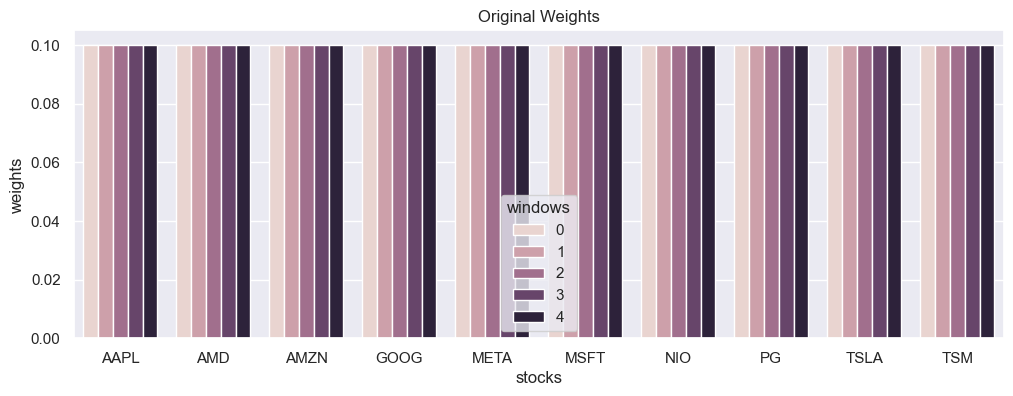

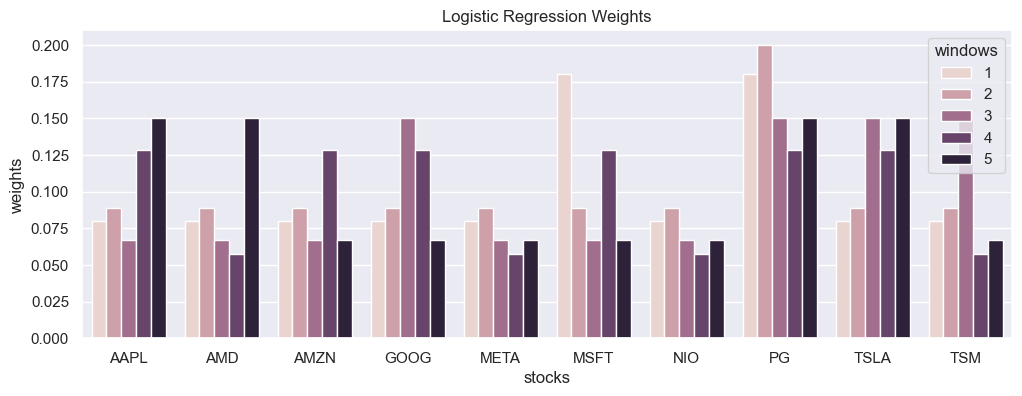

In [275]:
EWP_df = pd.DataFrame(np.ones((total_windows, N))/N, columns=stock_list).T
original_weight = EWP_df.T.iloc[:5].T
LR_df = pd.DataFrame(model_weights['LR'].T, columns=stock_list).T
LR_df.columns = range(1, total_windows+1)
LR_weight = LR_df.T.iloc[:5].T

# use sns to plot the barchart
fig, ax = plt.subplots(figsize=(12,4))
sns.set(style='darkgrid')
sns.barplot(x='stocks', y='weights', hue='windows', ax=ax, data=original_weight.reset_index().rename(columns={'index': 'stocks'}).melt(id_vars='stocks', var_name='windows', value_name='weights'))
plt.title('Original Weights')
plt.show()

fig, ax = plt.subplots(figsize=(12,4))
sns.set(style='darkgrid')
sns.barplot(x='stocks', y='weights', hue='windows', ax=ax, data=LR_weight.reset_index().rename(columns={'index': 'stocks'}).melt(id_vars='stocks', var_name='windows', value_name='weights'))
plt.title('Logistic Regression Weights')
plt.show()

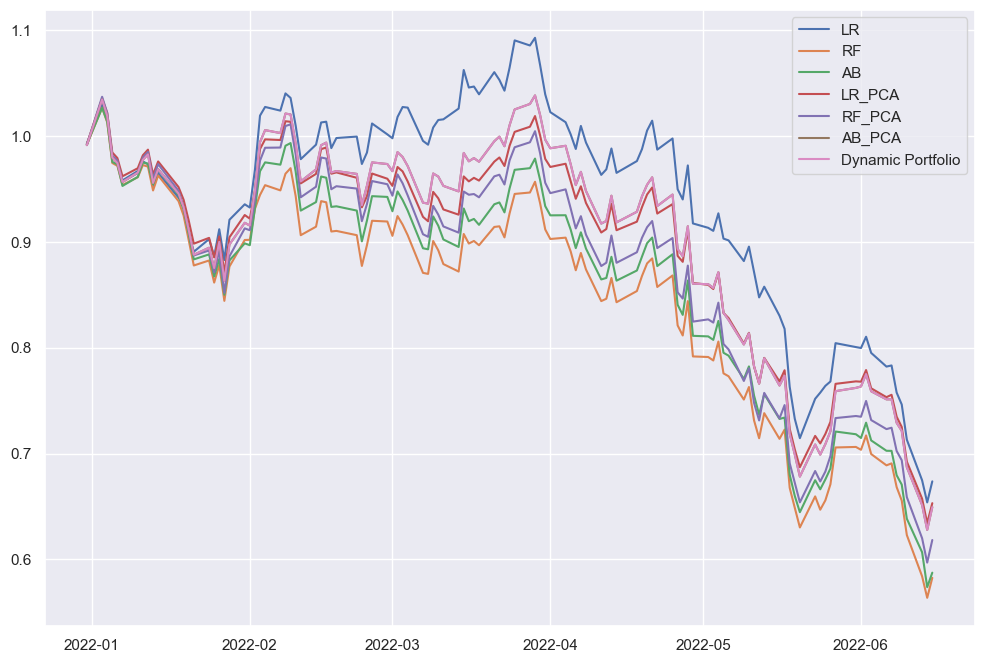

In [270]:
"""
try to adjust the weights based on the prediction_label
1. if the prediction and the weight have the same sign, increase the weight by 10%
2. if the prediction and the weight have the opposite sign, decrease the weight by 10%
3. normalize the weights
"""
match_weights = 1.2
models = ['LR', 'RF', 'AB', 'LR_PCA', 'RF_PCA', 'AB_PCA']
model_weights = {}
model_evaluation = pd.DataFrame(columns=models)
plt.figure(figsize=(12, 8))
for model in models:
    Pre_labels = np.vstack(label_df[model]) 
    MVP_weight = np.asarray(weights_df)
    Sign = np.sign(Pre_labels) * np.sign(MVP_weight)

    MVP_weight = MVP_weight * match_weights**Sign
    MVP_weight = MVP_weight / np.sum(MVP_weight, axis=0)
    
    
    model_weights[model] = MVP_weight

    temp_df = pd.DataFrame(MVP_weight, columns=range(1, total_windows+1), index=stock_list)
    static_return, dynamic_return, EWP_return = get_returns(temp_df, rebalance_period, total_windows)
    dynamic_plot = 1 + np.cumsum(dynamic_return)
    static_plot = 1 + np.cumsum(static_return)
    EWP_plot = 1 + np.cumsum(EWP_return)
    plt.plot(test_return.index[:len(dynamic_plot)], dynamic_plot, label=model)

    model_evaluation.loc['Annual Return', model] = round(emp.annual_return(dynamic_return), 4)
    model_evaluation.loc['Annual Volatility', model] = round(emp.annual_volatility(dynamic_return), 4)
    model_evaluation.loc['Sharpe Ratio', model] = round(emp.sharpe_ratio(dynamic_return), 4)
    model_evaluation.loc['Cumulative Return', model] = round(dynamic_plot[-1], 4)
    model_evaluation.loc['Max Drawdown', model] = round(emp.max_drawdown(dynamic_return), 4)
plt.plot(test_return.index[:len(dynamic_plot)], dynamic_plot, label='Dynamic Portfolio')
plt.legend()
plt.show()


In [271]:
model_evaluation.join(evaluation)

,LR,RF,AB,LR_PCA,RF_PCA,AB_PCA,Dynamic Portfolio,Static Portfolio,EWP Portfolio
Annual Return,-0.5377,-0.6204,-0.6164,-0.5564,-0.5925,-0.5626,-0.5637,-0.6033,-0.6112
Annual Volatility,0.3342,0.3236,0.3244,0.3217,0.3462,0.339,0.3263,0.4061,0.4296
Sharpe Ratio,-2.139,-2.8268,-2.7867,-2.3629,-2.4156,-2.2658,-2.3753,-2.0702,-1.9814
Cumulative Return,0.6738,0.5826,0.5875,0.6532,0.6183,0.6494,0.6463,0.6163,0.6116
Max Drawdown,-0.3643,-0.3855,-0.3794,-0.3458,-0.3731,-0.351,-0.3474,-0.3823,-0.3958


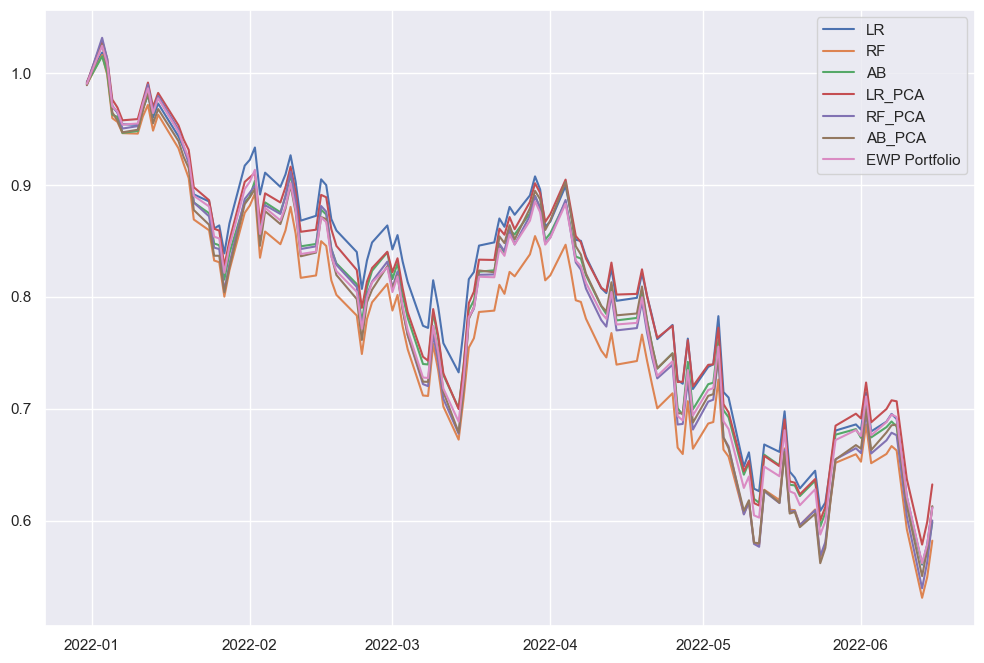

In [272]:
"""
try to adjust the weights based on the prediction_label
1. if the prediction and the weight have the same sign, increase the weight by 10%
2. if the prediction and the weight have the opposite sign, decrease the weight by 10%
3. normalize the weights
"""
match_weights = 1.5
models = ['LR', 'RF', 'AB', 'LR_PCA', 'RF_PCA', 'AB_PCA']
model_weights = {}
model_evaluation = pd.DataFrame(columns=models)
plt.figure(figsize=(12, 8))
for model in models:
    Pre_labels = np.vstack(label_df[model]) 
    EWP_weight = np.zeros(N) + 1/N
    # cast the EWP_weight for total_windows times
    EWP_weight = np.tile(EWP_weight, (total_windows, 1)).T
    Sign = np.sign(Pre_labels) * np.sign(EWP_weight) 
    EWP_weight = EWP_weight * match_weights**Sign
    EWP_weight = EWP_weight / np.sum(EWP_weight, axis=0)
    model_weights[model] = EWP_weight

    temp_df = pd.DataFrame(EWP_weight, columns=range(1, total_windows+1), index=stock_list)
    static_return, dynamic_return, EWP_return = get_returns(temp_df, rebalance_period, total_windows)
    dynamic_plot = 1 + np.cumsum(dynamic_return)
    static_plot = 1 + np.cumsum(static_return)
    EWP_plot = 1 + np.cumsum(EWP_return)
    plt.plot(test_return.index[:len(dynamic_plot)], dynamic_plot, label=model)

    model_evaluation.loc['Annual Return', model] = round(emp.annual_return(dynamic_return), 4)
    model_evaluation.loc['Annual Volatility', model] = round(emp.annual_volatility(dynamic_return), 4)
    model_evaluation.loc['Sharpe Ratio', model] = round(emp.sharpe_ratio(dynamic_return), 4)
    model_evaluation.loc['Cumulative Return', model] = round(dynamic_plot[-1], 4)
    model_evaluation.loc['Max Drawdown', model] = round(emp.max_drawdown(dynamic_return), 4)
plt.plot(test_return.index[:len(dynamic_plot)], EWP_plot, label='EWP Portfolio')
plt.legend()
plt.show()


In [273]:
model_evaluation.join(evaluation)

,LR,RF,AB,LR_PCA,RF_PCA,AB_PCA,Dynamic Portfolio,Static Portfolio,EWP Portfolio
Annual Return,-0.6077,-0.6353,-0.6199,-0.5917,-0.626,-0.6151,-0.5637,-0.6033,-0.6112
Annual Volatility,0.41,0.427,0.4131,0.4216,0.4597,0.4582,0.3263,0.4061,0.4296
Sharpe Ratio,-2.0733,-2.145,-2.1312,-1.9113,-1.9067,-1.8515,-2.3753,-2.0702,-1.9814
Cumulative Return,0.6121,0.582,0.5982,0.6323,0.6,0.6128,0.6463,0.6163,0.6116
Max Drawdown,-0.3908,-0.4093,-0.3888,-0.3871,-0.4166,-0.4066,-0.3474,-0.3823,-0.3958
